[View in Colaboratory](https://colab.research.google.com/github/sl2820/Deep_Learning_Study/blob/master/Convolutional_Neural_Network_Number_Classification.ipynb)

# CONVOLUTIONAL NEURAL NETWORK


In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
% matplotlib inline
print ("Current TF Version [%s]" % (tf.__version__))
print ("Package Loaded")

Current TF Version [1.11.0-rc2]
Package Loaded


### Load MNIST

In [2]:
mnist = input_data.read_data_sets("data/", one_hot=True)
trainimg = mnist.train.images
trainlabel = mnist.train.labels
testimg = mnist.test.images
testlabel = mnist.test.labels
print ("MNIST Ready")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
MN

### Define Model

In [3]:
# Network Topologies
n_input = 784 # 28 x 28 images
n_channel = 64 # Number of Convolution Filter
n_classes = 10  # Number of categories --> for us, 0 to 9

# Inputs and Outputs
x = tf.placeholder("float", [None, n_input])   # ? x 784
y = tf.placeholder("float", [None, n_classes])  # ? x 10

# Network Parameters --> Convolution 2 layer + Dense Layer 1
stddev = 0.1
weights = {
    'c1': tf.Variable(tf.random_normal([3,3,1, n_channel], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([3,3,n_channel, 128], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([7*7*128, n_classes], stddev=stddev))
}
biases = {
    'c1': tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([128], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([n_classes], stddev=stddev))
}

print ("NETWORK READY")

NETWORK READY


### Define Graph

In [4]:
# Model
def CNN (_x, _w, _b):
    # Reshape
    _x_r = tf.reshape(_x, shape = [-1, 28, 28, 1])
    # Convolution
    _conv1 = tf.nn.conv2d (_x_r, _w['c1'], strides=[1,1,1,1], padding='SAME')
    # Add Bias
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # ReLU
    _conv3 = tf.nn.relu(_conv2)
    # Max-Pooling
    _pool = tf.nn.max_pool(_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    # Second Conv Layer
    _temp = tf.nn.conv2d(_pool, _w['c2'], strides=[1,1,1,1], padding = 'SAME')
    _temp = tf.nn.bias_add(_temp, _b['c2'])
    _temp = tf.nn.relu(_temp)
    _temp = tf.nn.max_pool(_temp, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    # Vectorize --> 한줄로 펴기
    _dense = tf.reshape(_temp, [-1,_w['d1'].get_shape().as_list()[0]])
    
    # Dense
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    _out = {
        'x_r': _x_r, 
        'conv1': _conv1, 
        'conv2': _conv2, 
        'conv3': _conv3,
        'pool': _pool, 
        'dense': _dense, 
        'logit': _logit
    }
    return _out

# Prediction
cnnout = CNN(x, weights, biases)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(cnnout['logit'],1), tf.argmax(y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))

#Initializer
init = tf.global_variables_initializer()
print ("Functions Ready")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Functions Ready


### Saver

In [5]:
savedir = "practice_nets/cnn_mnist_simple/"
saver = tf.train.Saver(max_to_keep=10)
save_step = 1
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("Saver Ready")

Saver Ready


### Runnn

In [6]:
# Parameters
training_epochs = 10
batch_size = 100
display_step = 2

# Launch the Graph
sess = tf.Session()
sess.run(init)

# Optimize
for epoch in range (training_epochs):
    avg_cost = 0
    total_batch = int (mnist.train.num_examples/batch_size)
    # iteration
    for i in range (total_batch):
        batch_x, batch_y, = mnist.train.next_batch(batch_size)
        feeds = {x: batch_x, y: batch_y}
        sess.run(optm, feed_dict = feeds)
        avg_cost+=sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch

    # Display
    if (epoch+1) % display_step == 0:
        print ("Epoch : %03d/%03d Cost : %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_x, y: batch_y}
        train_acc = sess.run(accr, feed_dict=feeds)
        print ("TRAIN ACCURACY : %.3f" % (train_acc))
        feeds = {x: mnist.test.images[:100, :], y: mnist.test.labels[:100, :]}
        test_acc = sess.run(accr, feed_dict=feeds)
        print ("TEST ACCURACY: %.3f" % (test_acc))
    # SAVE
    if (epoch+1) % save_step == 0:
        savename = savedir+"net-"+str(epoch+1)+".ckpt"
        saver.save(sess, savename)
        print ("[%s] SAVED" % (savename))

print ("OPTIMIZATION FINISHED")

[practice_nets/cnn_mnist_simple/net-1.ckpt] SAVED
Epoch : 002/010 Cost : 0.050493768
TRAIN ACCURACY : 0.990
TEST ACCURACY: 0.990
[practice_nets/cnn_mnist_simple/net-2.ckpt] SAVED
[practice_nets/cnn_mnist_simple/net-3.ckpt] SAVED
Epoch : 004/010 Cost : 0.025766146
TRAIN ACCURACY : 0.990
TEST ACCURACY: 1.000
[practice_nets/cnn_mnist_simple/net-4.ckpt] SAVED
[practice_nets/cnn_mnist_simple/net-5.ckpt] SAVED
Epoch : 006/010 Cost : 0.014624618
TRAIN ACCURACY : 1.000
TEST ACCURACY: 0.980
[practice_nets/cnn_mnist_simple/net-6.ckpt] SAVED
[practice_nets/cnn_mnist_simple/net-7.ckpt] SAVED
Epoch : 008/010 Cost : 0.008705856
TRAIN ACCURACY : 1.000
TEST ACCURACY: 0.980
[practice_nets/cnn_mnist_simple/net-8.ckpt] SAVED
[practice_nets/cnn_mnist_simple/net-9.ckpt] SAVED
Epoch : 010/010 Cost : 0.004944209
TRAIN ACCURACY : 1.000
TEST ACCURACY: 0.970
[practice_nets/cnn_mnist_simple/net-10.ckpt] SAVED
OPTIMIZATION FINISHED


### Restore

In [7]:
do_restore = 1
if do_restore == 1:
    sess = tf.Session()
    epoch = 10
    savename = savedir+'net-'+str(epoch)+'.ckpt'
    saver.restore(sess, savename)
    print ("Network Restored")
else:
    print ("Do nothing")

INFO:tensorflow:Restoring parameters from practice_nets/cnn_mnist_simple/net-10.ckpt
Network Restored


### Let's See How CNN Works

In [0]:
input_r = sess.run(cnnout['x_r'], feed_dict = {x: trainimg[0:1, :]})
conv1 = sess.run(cnnout['conv1'],feed_dict={x: trainimg[0:1, :]})
conv2 = sess.run(cnnout['conv2'],feed_dict={x: trainimg[0:1, :]})
conv3n = sess.run(cnnout['conv3'],feed_dict={x: trainimg[0:1, :]})
pool = sess.run(cnnout['pool'],feed_dict={x: trainimg[0:1, :]})
dense = sess.run(cnnout['dense'],feed_dict={x: trainimg[0:1, :]})
out = sess.run(cnnout['logit'],feed_dict={x: trainimg[0:1, :]})




### Input

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


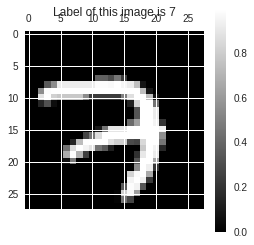

In [9]:
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0,:])
print ("Label is %d" % (label))

#Plot
plt.matshow(input_r[0,:,:,0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label)+"")
plt.colorbar()
plt.show()

### Conv Steps

Size of 'Conv1' is (1, 28, 28, 64)


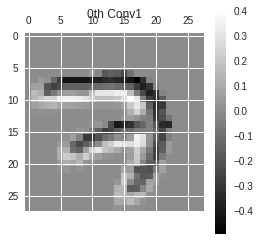

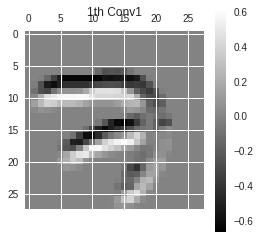

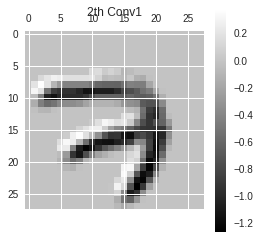

In [10]:
print ("Size of 'Conv1' is %s" % (conv1.shape,))
for i in range (3):
    plt.matshow(conv1[0,:,:,i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + 'th Conv1')
    plt.colorbar()
    plt.show()

### Conv + Bias (Conv2)

Size of 'Conv2' is (1, 28, 28, 64)


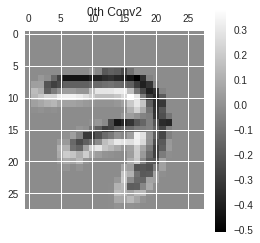

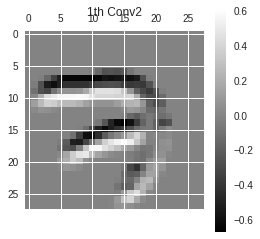

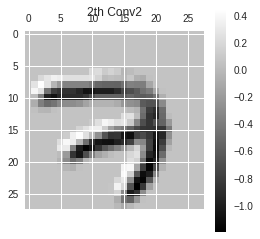

In [11]:
print ("Size of 'Conv2' is %s" % (conv2.shape,))   # Conv2 is bias added one
for i in range (3):
    plt.matshow(conv2[0,:,:,i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + 'th Conv2')
    plt.colorbar()
    plt.show()

### Conv + Bias + ReLU -- Conv3

In [12]:
print ("Size of 'Conv3' is %s" % (conv3n.shape,))
for i in range (3):
    plt.matshow(conv3[0,:,:,i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + 'th Conv3')
    plt.colorbar()
    plt.show()

Size of 'Conv3' is (1, 28, 28, 64)


NameError: ignored

### Pool

Size of 'Conv1' is (1, 14, 14, 64)


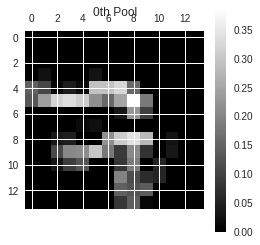

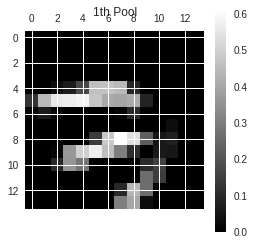

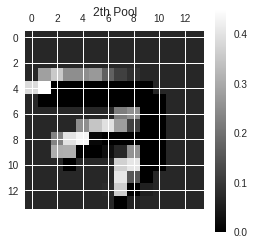

In [13]:
print ("Size of 'Conv1' is %s" % (pool.shape,))
for i in range (3):
    plt.matshow(pool[0,:,:,i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + 'th Pool')
    plt.colorbar()
    plt.show()

### Dense

Size of 'Dense' is (1, 6272)
Size of 'Out' is (1, 10)


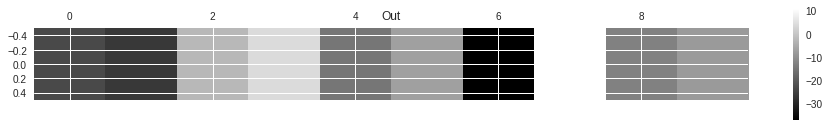

In [14]:
print ("Size of 'Dense' is %s" % (dense.shape,))
print ("Size of 'Out' is %s" % (out.shape,))
plt.matshow(out, cmap=plt.get_cmap('gray'))
plt.title('Out')
plt.colorbar()
plt.show()

### Convolutional Filter

Size of 'WC1' is (3, 3, 1, 64)


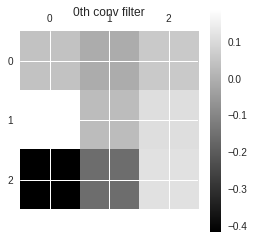

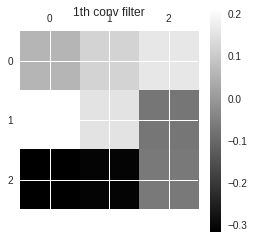

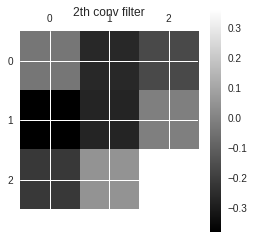

In [15]:
wc1 = sess.run(weights['c1'])
print ("Size of 'WC1' is %s" % (wc1.shape,))

for i in range (3):
    plt.matshow(wc1[:,:,0,i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + 'th conv filter')
    plt.colorbar()
    plt.show()